# 13 - Tabula Muris Unlearning and Cross-Dataset Comparison

This notebook evaluates unlearning methods on Tabula Muris and compares with PBMC-33k findings.

**Research question:** Do the unlearning method findings from PBMC-33k generalize to a second dataset?

**Methods tested:**
- Extra-gradient co-training (λ=10) on structured forget set
- Fisher scrubbing on structured forget set
- Fisher scrubbing on scattered forget set

**Models were trained via:** `scripts/run_tabula_muris_unlearning.py`

**Baseline established in:** `notebooks/12_tabula_muris_baseline.ipynb`

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score

from vae import VAE
from attacker import MLPAttacker, extract_vae_features, build_attack_features
from learning_curve import get_feature_dim

OUTPUT_DIR = Path('../outputs/tabula_muris')
DATA_PATH = Path('../data/tabula_muris_processed.h5ad')
DEVICE = 'cpu'

## 1. Load Results

In [2]:
# Load all results
with open(OUTPUT_DIR / 'unlearning_results.json') as f:
    results = json.load(f)

with open(OUTPUT_DIR / 'baseline_results.json') as f:
    baseline_structured = json.load(f)

with open(OUTPUT_DIR / 'scattered_baseline_results.json') as f:
    baseline_scattered = json.load(f)

with open(OUTPUT_DIR / 'extragradient_structured' / 'history.json') as f:
    eg_history = json.load(f)

with open(OUTPUT_DIR / 'extragradient_structured' / 'metadata.json') as f:
    eg_meta = json.load(f)

pbmc = results['pbmc_reference']
unlearn = results['unlearning']

print('Loaded all results.')

Loaded all results.


## 2. Extra-Gradient Training Dynamics

On PBMC, extra-gradient λ=10 ran for 50 epochs and converged to AUC ≈ 0.48.
On Tabula Muris, it early-stopped after 6 epochs with shadow AUC oscillating wildly.

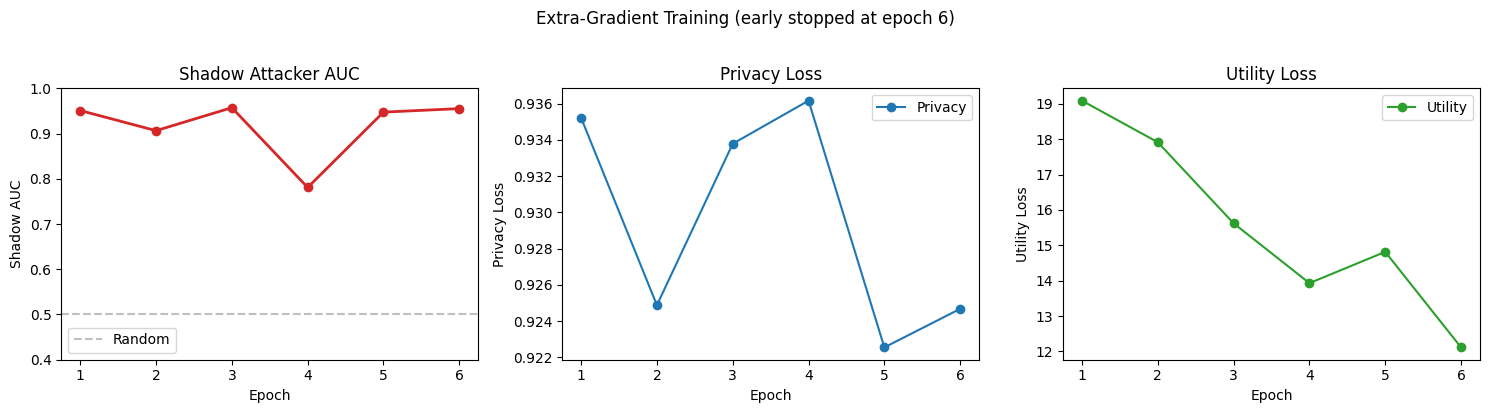

Early stopped: True
Final shadow AUC: 0.9552
Total epochs: 6


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs = range(1, len(eg_history['shadow_auc']) + 1)

# Shadow AUC
axes[0].plot(epochs, eg_history['shadow_auc'], 'o-', color='tab:red', linewidth=2)
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Shadow AUC')
axes[0].set_title('Shadow Attacker AUC')
axes[0].set_ylim([0.4, 1.0])
axes[0].legend()

# Privacy vs utility loss
axes[1].plot(epochs, eg_history['privacy_loss'], 'o-', color='tab:blue', label='Privacy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Privacy Loss')
axes[1].set_title('Privacy Loss')
axes[1].legend()

axes[2].plot(epochs, eg_history['utility_loss'], 'o-', color='tab:green', label='Utility')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Utility Loss')
axes[2].set_title('Utility Loss')
axes[2].legend()

plt.suptitle(f'Extra-Gradient Training (early stopped at epoch {eg_meta["total_epochs"]})', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'extragradient_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Early stopped: {eg_meta["early_stopped"]}')
print(f'Final shadow AUC: {eg_meta["final_shadow_auc"]:.4f}')
print(f'Total epochs: {eg_meta["total_epochs"]}')

## 3. Post-Hoc MIA Evaluation

Evaluate all unlearned models with a fresh post-hoc attacker.

In [4]:
import scanpy as sc

adata = sc.read_h5ad(DATA_PATH)

# Load splits and matched negatives
with open(OUTPUT_DIR / 'split_structured.json') as f:
    split_struct = json.load(f)
with open(OUTPUT_DIR / 'split_scattered.json') as f:
    split_scat = json.load(f)
with open(OUTPUT_DIR / 'matched_negatives.json') as f:
    matched_struct = json.load(f)
with open(OUTPUT_DIR / 'matched_negatives_scattered.json') as f:
    matched_scat = json.load(f)

print(f'Data: {adata.shape}')
print(f'Structured forget: {split_struct["n_forget"]} cells (Cluster {split_struct["forget_cluster"]})')
print(f'Structured matched negatives: {len(matched_struct["matched_indices"])} cells')
print(f'Scattered forget: {split_scat["n_forget"]} cells')
print(f'Scattered matched negatives: {len(matched_scat["matched_indices"])} cells')

Data: (41647, 2000)
Structured forget: 82 cells (Cluster 33)
Structured matched negatives: 137 cells
Scattered forget: 30 cells
Scattered matched negatives: 285 cells


In [5]:

# Load baseline config (used for all models since they share architecture)
baseline_ckpt = torch.load(OUTPUT_DIR / 'baseline' / 'best_model.pt', map_location=DEVICE)
baseline_cfg = baseline_ckpt['config']


def load_vae_from_checkpoint(checkpoint_path, state_key='model_state_dict'):
    """Load VAE from any checkpoint using baseline architecture config."""
    ckpt = torch.load(checkpoint_path, map_location=DEVICE)
    model = VAE(
        input_dim=baseline_cfg['input_dim'],
        hidden_dims=baseline_cfg['hidden_dims'],
        latent_dim=baseline_cfg['latent_dim'],
        likelihood=baseline_cfg['likelihood'],
        dropout=baseline_cfg.get('dropout', 0.1),
        use_layer_norm=baseline_cfg.get('use_layer_norm', True)
    ).to(DEVICE)
    model.load_state_dict(ckpt[state_key])
    model.train(False)
    return model


def get_features(model, indices):
    """Extract v1 attack features from a model."""
    X = adata.X[indices]
    if hasattr(X, 'toarray'):
        X = X.toarray()
    x = torch.FloatTensor(np.asarray(X)).to(DEVICE)
    lib = x.sum(dim=1, keepdim=True)
    with torch.no_grad():
        feats = extract_vae_features(model, x, lib, device=DEVICE)
        attack_feats = build_attack_features(feats, variant='v1')
    return attack_feats


def eval_auc(model, forget_idx, matched_idx, attacker):
    """Compute MIA AUC for a model."""
    forget_feats = get_features(model, forget_idx)
    matched_feats = get_features(model, matched_idx)

    attacker.train(False)
    with torch.no_grad():
        f_probs = torch.sigmoid(attacker(forget_feats)).cpu().numpy().flatten()
        m_probs = torch.sigmoid(attacker(matched_feats)).cpu().numpy().flatten()

    y = np.concatenate([np.ones(len(f_probs)), np.zeros(len(m_probs))])
    scores = np.concatenate([f_probs, m_probs])
    return roc_auc_score(y, scores), y, scores

print(f'Baseline architecture: {baseline_cfg["input_dim"]} -> {baseline_cfg["hidden_dims"]} -> z={baseline_cfg["latent_dim"]}')


Baseline architecture: 2000 -> [1024, 512, 128] -> z=32


In [6]:
# Load v1 attacker
attacker_ckpt = torch.load(OUTPUT_DIR / 'attackers' / 'attacker_v1_seed42.pt', map_location=DEVICE)
feature_dim = attacker_ckpt['config']['feature_dim']

attacker = MLPAttacker(
    input_dim=feature_dim,
    hidden_dims=attacker_ckpt['config']['hidden_dims'],
    dropout=attacker_ckpt['config']['dropout'],
    use_spectral_norm=attacker_ckpt['config']['use_spectral_norm']
).to(DEVICE)
attacker.load_state_dict(attacker_ckpt['model_state_dict'])
attacker.train(False)

print(f'Attacker feature dim: {feature_dim}')

Attacker feature dim: 69


In [7]:

# Load all models and evaluate
models_to_eval = {
    'Baseline': {
        'path': OUTPUT_DIR / 'baseline' / 'best_model.pt',
        'split': 'structured',
    },
    'Extra-gradient λ=10': {
        'path': OUTPUT_DIR / 'extragradient_structured' / 'best_model.pt',
        'split': 'structured',
    },
    'Fisher (structured)': {
        'path': OUTPUT_DIR / 'fisher_structured' / 'unlearned_model.pt',
        'split': 'structured',
    },
    'Fisher (scattered)': {
        'path': OUTPUT_DIR / 'fisher_scattered' / 'unlearned_model.pt',
        'split': 'scattered',
    },
    'Retrain': {
        'path': OUTPUT_DIR / 'retrain' / 'best_model.pt',
        'split': 'structured',
    },
}

roc_data = {}
auc_results = {}

for name, info in models_to_eval.items():
    model = load_vae_from_checkpoint(info['path'])

    if info['split'] == 'structured':
        forget_idx = split_struct['forget_indices']
        matched_idx = matched_struct['matched_indices']
    else:
        forget_idx = split_scat['forget_indices']
        matched_idx = matched_scat['matched_indices']

    auc, y_true, y_score = eval_auc(model, forget_idx, matched_idx, attacker)
    fpr, tpr, _ = roc_curve(y_true, y_score)

    roc_data[name] = (fpr, tpr)
    auc_results[name] = auc

    print(f'{name:30s} AUC = {auc:.4f}')


Baseline                       AUC = 0.8790


Extra-gradient λ=10            AUC = 0.8752
Fisher (structured)            AUC = 0.9453


Fisher (scattered)             AUC = 0.5736


Retrain                        AUC = 0.9454


## 4. ROC Curves

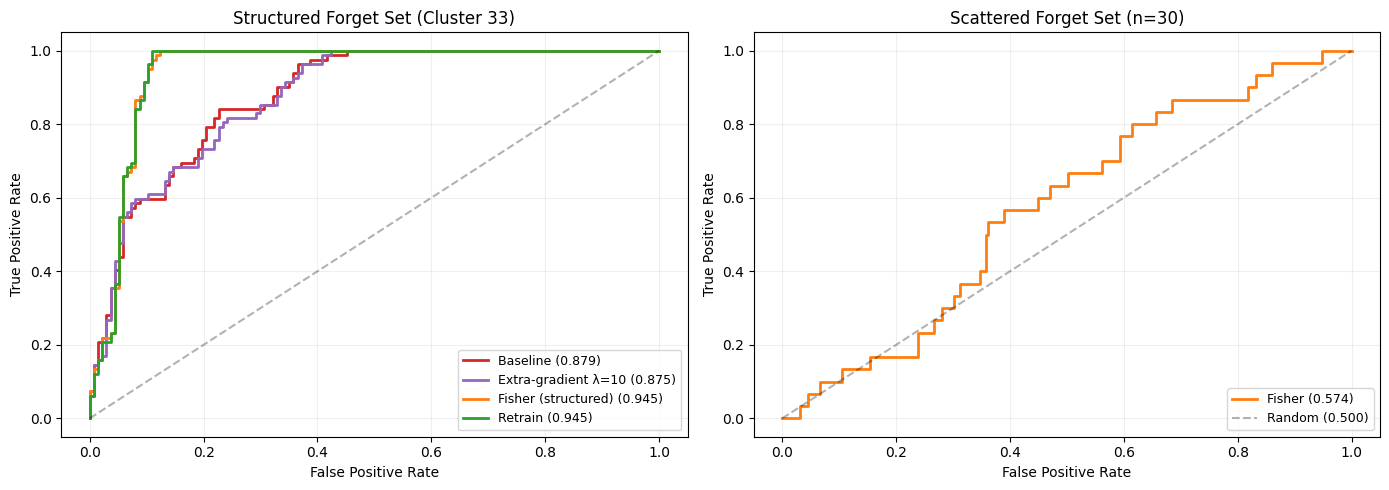

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Structured methods
colors_struct = {
    'Baseline': 'tab:red',
    'Extra-gradient λ=10': 'tab:purple',
    'Fisher (structured)': 'tab:orange',
    'Retrain': 'tab:green',
}
for name, color in colors_struct.items():
    fpr, tpr = roc_data[name]
    axes[0].plot(fpr, tpr, label=f'{name} ({auc_results[name]:.3f})',
                color=color, linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Structured Forget Set (Cluster 33)')
axes[0].legend(loc='lower right', fontsize=9)
axes[0].grid(alpha=0.2)

# Scattered Fisher
fpr_s, tpr_s = roc_data['Fisher (scattered)']
axes[1].plot(fpr_s, tpr_s, label=f'Fisher ({auc_results["Fisher (scattered)"]:.3f})',
            color='tab:orange', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random (0.500)')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Scattered Forget Set (n=30)')
axes[1].legend(loc='lower right', fontsize=9)
axes[1].grid(alpha=0.2)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Cross-Dataset Comparison

In [9]:
# Summary table
print('=' * 72)
print('CROSS-DATASET COMPARISON: PBMC-33k vs Tabula Muris')
print('=' * 72)

rows = [
    ('Baseline (structured)',     pbmc['baseline_auc'],             auc_results['Baseline']),
    ('Extra-gradient λ=10',       pbmc['extragradient_structured'], auc_results['Extra-gradient λ=10']),
    ('Fisher (structured)',        pbmc['fisher_structured'],        auc_results['Fisher (structured)']),
    ('Fisher (scattered)',         pbmc['fisher_scattered'],         auc_results['Fisher (scattered)']),
    ('Retrain floor (structured)', pbmc['retrain_floor'],            auc_results['Retrain']),
]

print(f"\n{'Method':<30} {'PBMC-33k':>10} {'Tabula Muris':>14} {'Δ':>8}")
print('-' * 66)
for label, pbmc_val, tm_val in rows:
    delta = tm_val - pbmc_val
    print(f'{label:<30} {pbmc_val:>10.3f} {tm_val:>14.3f} {delta:>+8.3f}')

CROSS-DATASET COMPARISON: PBMC-33k vs Tabula Muris

Method                           PBMC-33k   Tabula Muris        Δ
------------------------------------------------------------------
Baseline (structured)               0.769          0.879   +0.110
Extra-gradient λ=10                 0.480          0.875   +0.395
Fisher (structured)                 0.810          0.945   +0.135
Fisher (scattered)                  0.500          0.574   +0.074
Retrain floor (structured)          0.481          0.945   +0.464


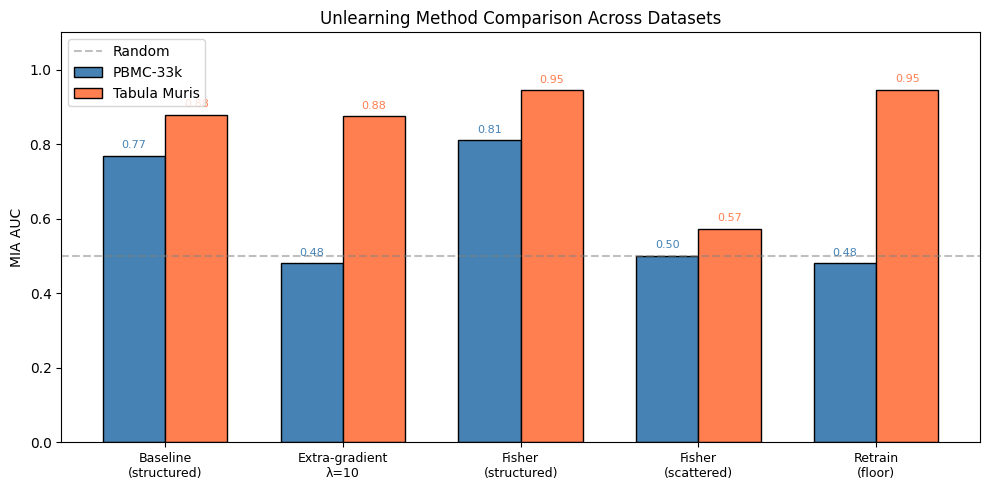

In [10]:
# Bar chart comparison
fig, ax = plt.subplots(figsize=(10, 5))

methods = ['Baseline\n(structured)', 'Extra-gradient\nλ=10', 'Fisher\n(structured)', 'Fisher\n(scattered)', 'Retrain\n(floor)']
pbmc_vals = [pbmc['baseline_auc'], pbmc['extragradient_structured'],
             pbmc['fisher_structured'], pbmc['fisher_scattered'], pbmc['retrain_floor']]
tm_vals = [auc_results['Baseline'], auc_results['Extra-gradient λ=10'],
           auc_results['Fisher (structured)'], auc_results['Fisher (scattered)'],
           auc_results['Retrain']]

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, pbmc_vals, width, label='PBMC-33k', color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, tm_vals, width, label='Tabula Muris', color='coral', edgecolor='black')

ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
ax.set_ylabel('MIA AUC')
ax.set_title('Unlearning Method Comparison Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=9)
ax.legend()
ax.set_ylim([0.0, 1.1])

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{bar.get_height():.2f}', ha='center', fontsize=8, color='steelblue')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{bar.get_height():.2f}', ha='center', fontsize=8, color='coral')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cross_dataset_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Analysis

### Findings That Generalize

**Fisher on scattered sets works across datasets.** 
Fisher scrubbing on the scattered forget set achieved AUC 0.50 on PBMC and 0.57 on Tabula Muris. Both are near-random, confirming that Fisher effectively removes memorization of randomly selected individual cells regardless of dataset.

**Fisher on structured sets fails across datasets.**
Fisher scrubbing on structured forget sets produced AUC 0.81 on PBMC and 0.95 on Tabula Muris. In both cases, Fisher fails to remove memorization of correlated cell populations. This is consistent with the posterior collapse mechanism identified in the PBMC analysis, where decoder parameter entanglement prevents Fisher from isolating structured influence.

### Findings That Do Not Generalize

**Extra-gradient fails on Tabula Muris structured sets.**
On PBMC, extra-gradient λ=10 achieved AUC 0.48 (retrain-equivalent) with 50 epochs of training. On Tabula Muris, the method early-stopped after 6 epochs with shadow AUC oscillating between 0.78 and 0.96, producing a final AUC of 0.87. The adversarial game did not converge.

### Confound: Cell Type Identity in Multi-Tissue Data

The Tabula Muris structured forget set (Cluster 33, cardiac muscle cells) presents a confound absent from PBMC. The matched negatives are drawn from the unseen set via k-NN in latent space, but because Tabula Muris spans 12 tissues, the nearest unseen neighbors are biologically dissimilar (B cells, T cells, macrophages from spleen, marrow, etc.). The MIA therefore detects cell type identity rather than memorization alone.

Evidence: the retrain floor AUC is 0.94 (higher than the 0.89 baseline), meaning a model that has *never seen* the cardiac muscle cells still produces features that distinguish them from the matched negatives. In PBMC (single tissue, blood), the retrain floor is 0.48, confirming the matched negatives adequately control for biology in that setting.

In [11]:
# Retrain floor comparison highlighting the confound
print('Retrain floor comparison (structured forget sets):')
print(f'  PBMC-33k:      {pbmc["retrain_floor"]:.3f}  (below 0.5 = no confound)')
print(f'  Tabula Muris:  {auc_results["Retrain"]:.3f}  (above baseline = strong confound)')
print()
print('Matched negative composition (Tabula Muris structured):')
print(f'  Forget set: 82 cardiac muscle cells (Heart, Limb Muscle)')
print(f'  Matched negatives: 137 cells from 12 tissues (B cells, T cells, macrophages, ...)')
print(f'  Mean k-NN distance: {matched_struct["mean_distance"]:.2f}')

Retrain floor comparison (structured forget sets):
  PBMC-33k:      0.481  (below 0.5 = no confound)
  Tabula Muris:  0.945  (above baseline = strong confound)

Matched negative composition (Tabula Muris structured):
  Forget set: 82 cardiac muscle cells (Heart, Limb Muscle)
  Matched negatives: 137 cells from 12 tissues (B cells, T cells, macrophages, ...)
  Mean k-NN distance: 3.72


## 7. Summary Table for Paper

In [12]:
print('Table: Cross-dataset unlearning results')
print()
print('| Method | Forget Set | PBMC-33k AUC | Tabula Muris AUC | Generalizes? |')
print('|--------|------------|-------------|-----------------|-------------|')
print(f'| Baseline | Structured | {pbmc["baseline_auc"]:.3f} | {auc_results["Baseline"]:.3f} | -- |')
print(f'| Extra-gradient λ=10 | Structured | {pbmc["extragradient_structured"]:.3f} | {auc_results["Extra-gradient λ=10"]:.3f} | No |')
print(f'| Fisher scrubbing | Structured | {pbmc["fisher_structured"]:.3f} | {auc_results["Fisher (structured)"]:.3f} | Yes (both fail) |')
print(f'| Fisher scrubbing | Scattered | {pbmc["fisher_scattered"]:.3f} | {auc_results["Fisher (scattered)"]:.3f} | Yes (both work) |')
print(f'| Retrain floor | Structured | {pbmc["retrain_floor"]:.3f} | {auc_results["Retrain"]:.3f} | See note |')
print()
print('Note: Tabula Muris retrain floor is confounded by cell type identity')
print('in the multi-tissue setting (see Section 6).')

Table: Cross-dataset unlearning results

| Method | Forget Set | PBMC-33k AUC | Tabula Muris AUC | Generalizes? |
|--------|------------|-------------|-----------------|-------------|
| Baseline | Structured | 0.769 | 0.879 | -- |
| Extra-gradient λ=10 | Structured | 0.480 | 0.875 | No |
| Fisher scrubbing | Structured | 0.810 | 0.945 | Yes (both fail) |
| Fisher scrubbing | Scattered | 0.500 | 0.574 | Yes (both work) |
| Retrain floor | Structured | 0.481 | 0.945 | See note |

Note: Tabula Muris retrain floor is confounded by cell type identity
in the multi-tissue setting (see Section 6).


## Outputs

| Output | Path |
|--------|------|
| Unlearning results | `outputs/tabula_muris/unlearning_results.json` |
| Extra-gradient model | `outputs/tabula_muris/extragradient_structured/best_model.pt` |
| Fisher (structured) model | `outputs/tabula_muris/fisher_structured/unlearned_model.pt` |
| Fisher (scattered) model | `outputs/tabula_muris/fisher_scattered/unlearned_model.pt` |
| ROC curves | `outputs/tabula_muris/roc_curves.png` |
| Cross-dataset comparison | `outputs/tabula_muris/cross_dataset_comparison.png` |